In [1]:
import pickle
from ast import literal_eval
import pandas as pd
import numpy as np
import random
import os

from sklearn import metrics
from sklearn.cluster import SpectralClustering

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import textwrap

from statannotations.Annotator import Annotator
import itertools

import networkx as nx
from scipy.spatial.distance import squareform

In [2]:
phrog_palette = {
    'DNA, RNA and nucleotide metabolism': 'red',
    'connector': 'blue',
    'head and packaging': 'green',
    'integration and excision': 'pink',
    'lysis': 'gray',
    'moron, auxiliary metabolic gene and host takeover': 'brown',
    'other': 'purple',
    'tail': 'darkorange',
    'transcription regulation': 'cyan'
}

In [3]:
df = pd.read_csv('phrog_family_vectors_data.csv')

In [4]:
phrog_metadata = pd.read_csv('../general_data_files/PHROG_index_revised_v4_10292022.csv')

# supplemental figure 3a

In [5]:
phrog_dists = phrog_metadata.merge(right=df, how='outer', on='#phrog')
phrog_dists = phrog_dists[~phrog_dists['revised_category_v4'].isin(['unknown function'])]
phrog_dists.sort_values(by='revised_category_v4', inplace=True)

In [6]:
cs = set(phrog_dists['revised_category_v4'])

In [7]:
phrog_dists_thresholded_for_intra_family = phrog_dists[phrog_dists['mean_vector_sim'] < 0.999]

In [8]:
max_width=17
plt.rcParams['font.size'] = 28
plt.rcParams["figure.figsize"] = (12,12)

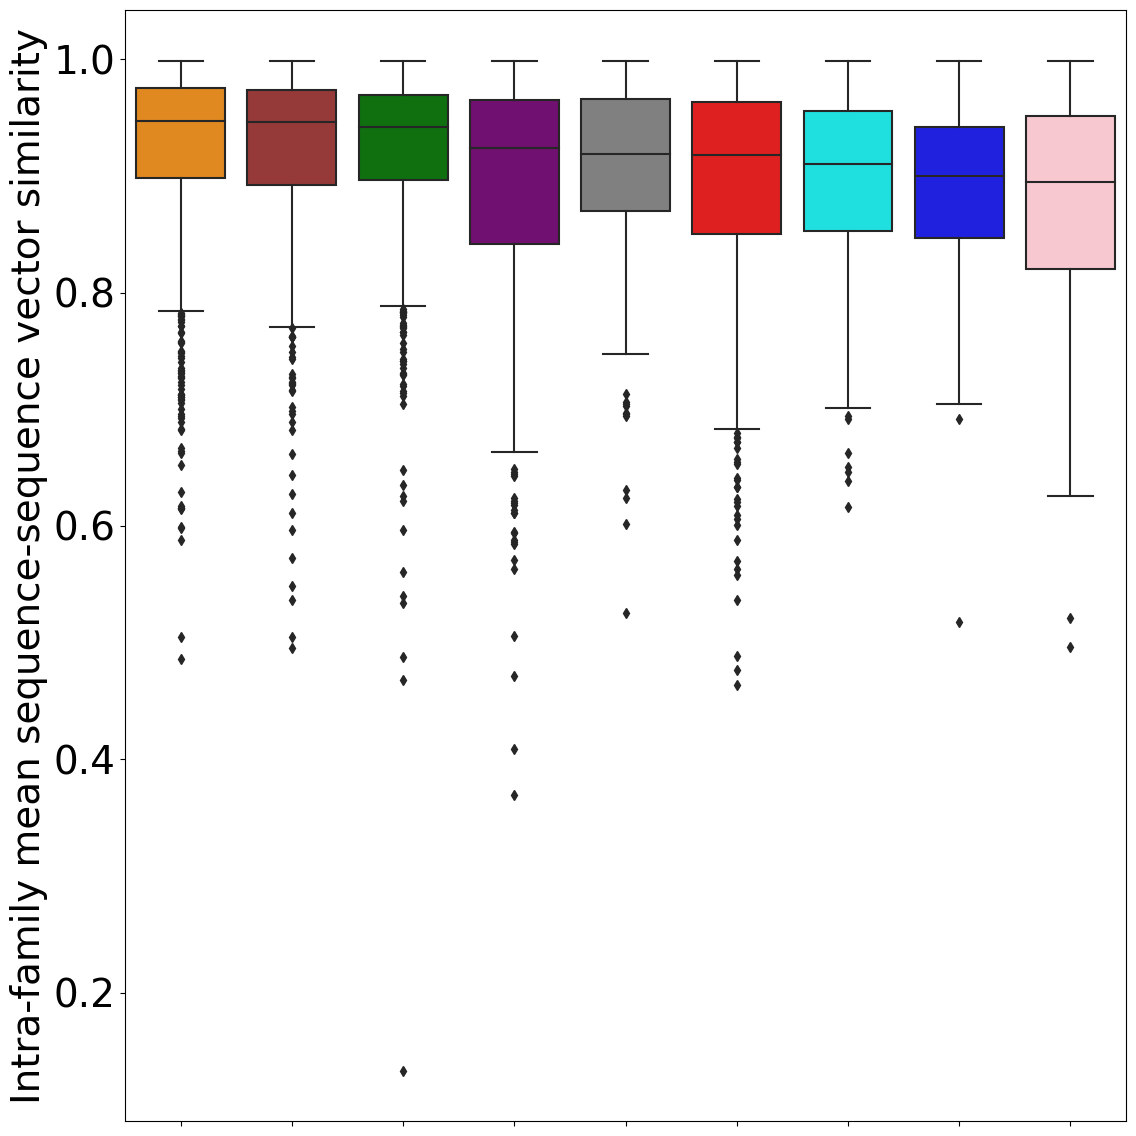

In [9]:
# Find the order
y='mean_vector_sim'
x='revised_category_v4'

my_order = phrog_dists_thresholded_for_intra_family .groupby(by=[x])[y].median().sort_values(ascending=False).index

ax = sns.boxplot(
    x=x,
    y=y,
    palette=phrog_palette,
    data=phrog_dists_thresholded_for_intra_family ,
    order=my_order
)



#ax.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels())
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#ax.set_xlabel('Category')

ax.set_xlabel('')
ax.set_xticklabels('' for x in ax.get_xticklabels())
ax.set_ylabel('Intra-family mean sequence-sequence vector similarity')

plt.tight_layout()
plt.savefig('family_mean_vector_similarity.png', dpi=300)

# supplemental figure 3c (left)

In [10]:
max_width=17
plt.rcParams['font.size'] = 16
plt.rcParams["figure.figsize"] = (12,12)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

lysis vs. DNA, RNA and nucleotide metabolism: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=1.344e+00
DNA, RNA and nucleotide metabolism vs. transcription regulation: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=5.351e-01
connector vs. integration and excision: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=1.581e+00
transcription regulation vs. connector: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=7.292e-01
moron, auxiliary metabolic gene and host takeover vs. head and packaging: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-1.282e+00
head and packaging vs. other: t-test independent samples with Bonferroni correction, P_val:1.014e-11 t=7.374e+00
other vs. lysis: t-test i

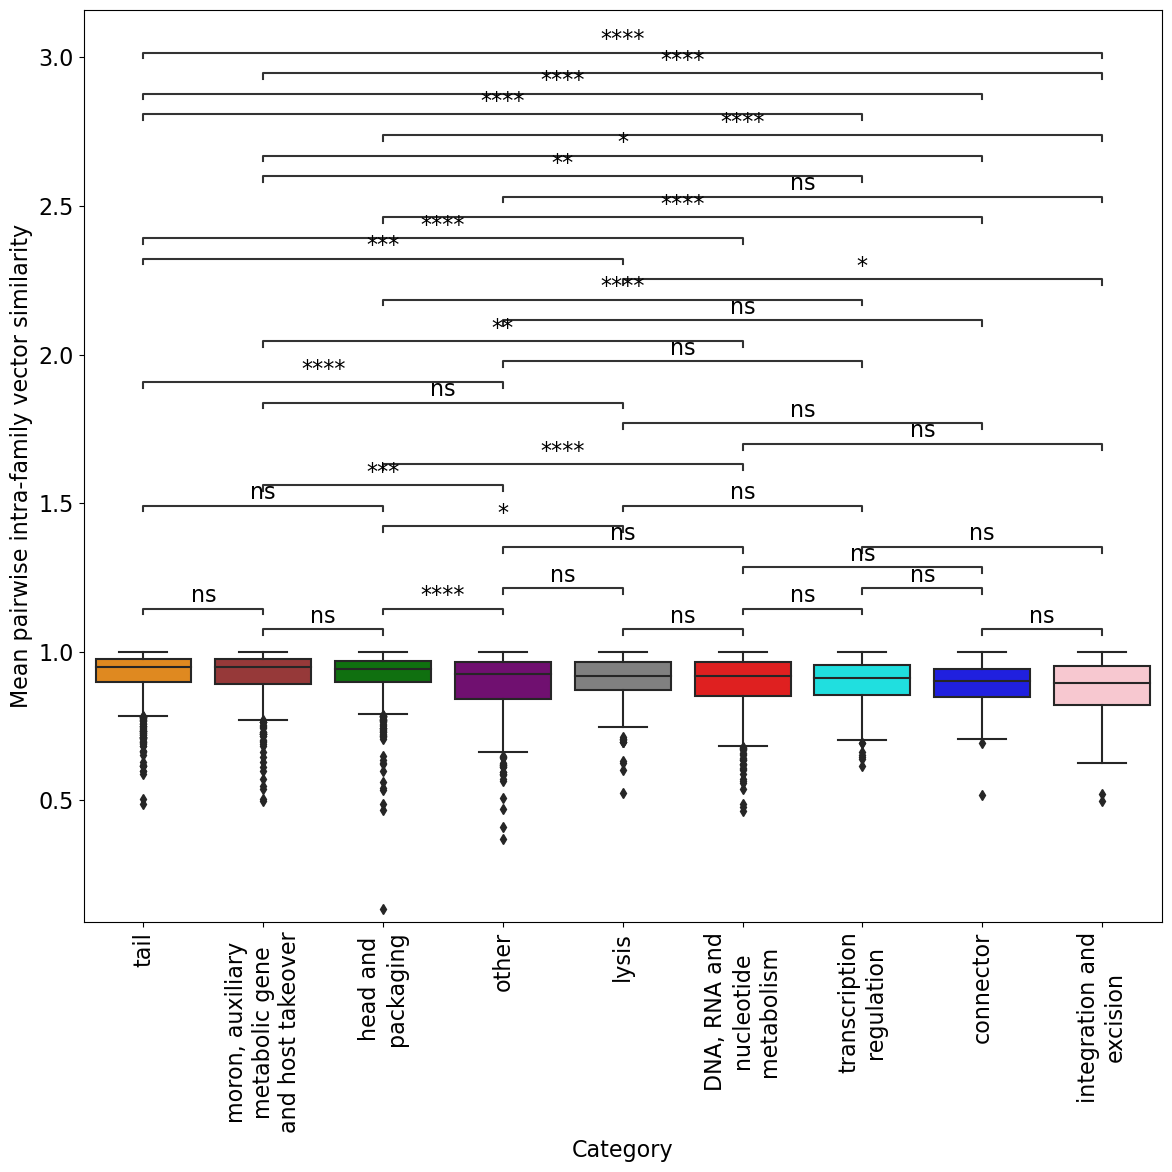

In [11]:
vals = [x for x in phrog_dists_thresholded_for_intra_family ['revised_category_v4'].unique()]
pairs = list(itertools.combinations(vals,2))

ax = sns.boxplot(
    y='mean_vector_sim',
    x='revised_category_v4',
    palette=phrog_palette,
    data=phrog_dists_thresholded_for_intra_family ,
    order=my_order
)
ax.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.set_xlabel('Category')
ax.set_ylabel('Mean pairwise intra-family vector similarity')



annotator = Annotator(ax, 
                      pairs, 
                      data=phrog_dists_thresholded_for_intra_family , 
                      y='mean_vector_sim',
                      x='revised_category_v4',
                      order=my_order)
annotator.configure(test='t-test_ind', text_format='star', comparisons_correction='bonferroni', verbose=1)
annotator.apply_and_annotate();

plt.tight_layout()

# supplemental figure 3b

In [12]:
cat_dists = []
for c in cs:
    d = phrog_dists[phrog_dists['revised_category_v4'] == c]
    vecs = []
    for ph in d['#phrog']:
        vecs.append(pickle.load(open('phrog_centroid/{0}.pkl' ''.format(ph), 'rb')))
    vecs = np.array(vecs)
    sims = metrics.pairwise.cosine_similarity(vecs)
    u_sims = sims[np.triu_indices(n=len(sims), k=1)]
    m_sims = np.mean(u_sims)
    median_sims = np.median(u_sims)
    
    cat_dists.append(zip([c]*len(u_sims), u_sims))

cat_dists = [x for y in cat_dists for x in y]
df_cat_dists = pd.DataFrame(cat_dists, columns=['revised_category_v4', 'similarity'])
df_cat_dists.sort_values(by='revised_category_v4', inplace=True)

In [13]:
plt.rcParams['font.size'] = 28
plt.rcParams["figure.figsize"] = (12,12)

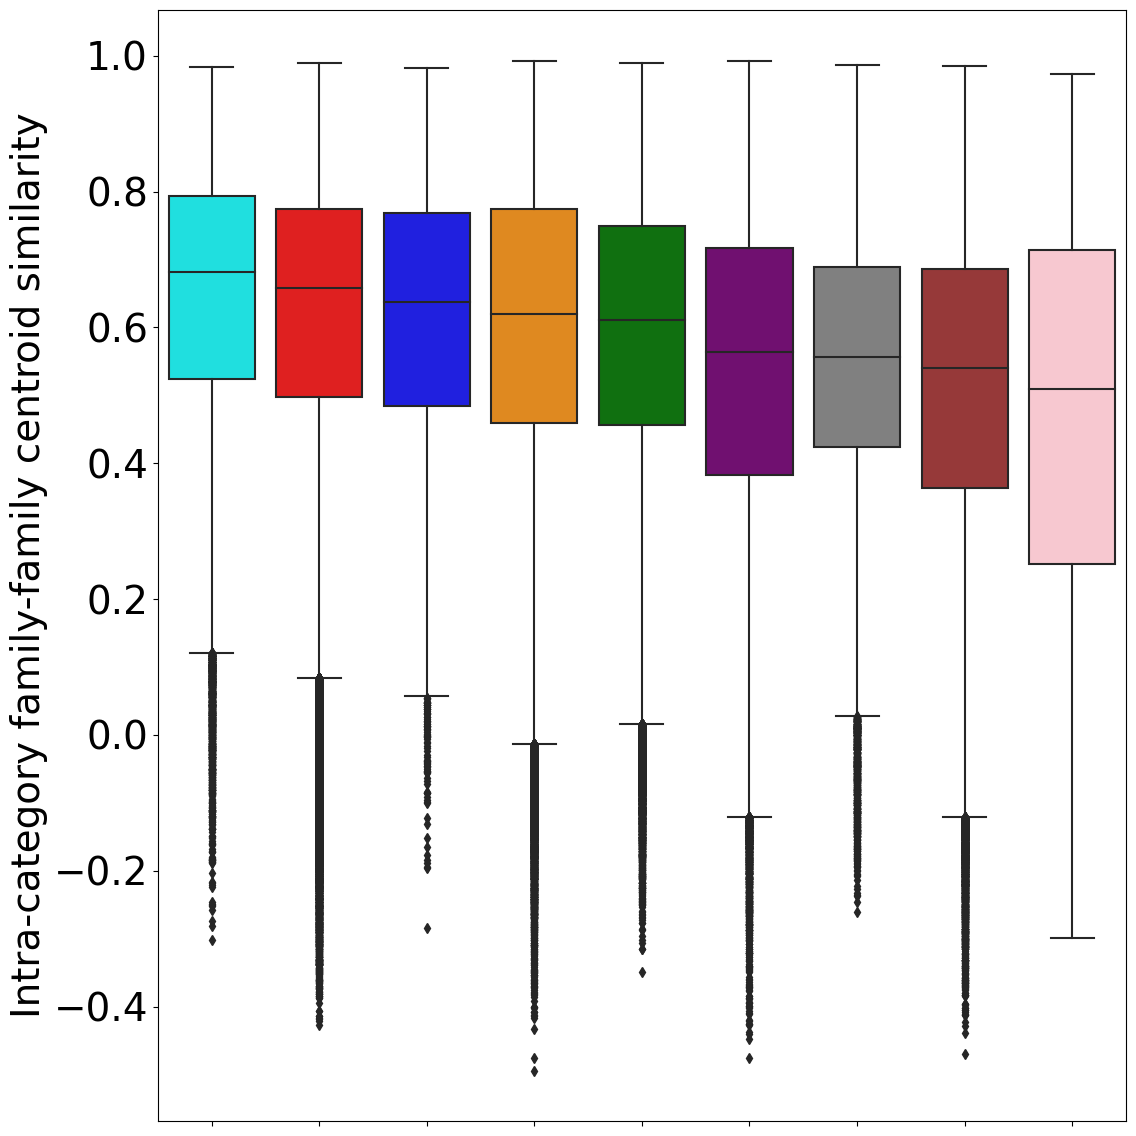

In [14]:
y='similarity'
x='revised_category_v4'

my_order = df_cat_dists.groupby(by=[x])[y].median().sort_values(ascending=False).index

ax = sns.boxplot(
    x=x,
    y=y,
    palette=phrog_palette,
    data=df_cat_dists,
    order=my_order
)
#ax.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels())
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_xticklabels('' for x in ax.get_xticklabels())
ax.set_ylabel('Intra-category family-family centroid similarity')

plt.tight_layout()
plt.savefig('intra_category_family_centroid_similarities.png', dpi=300)

# supplemental figure 3c (right)

In [15]:
plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams['font.size'] = 16

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DNA, RNA and nucleotide metabolism vs. connector: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-2.889e-02
transcription regulation vs. DNA, RNA and nucleotide metabolism: t-test independent samples with Bonferroni correction, P_val:1.010e-111 t=2.262e+01
connector vs. tail: t-test independent samples with Bonferroni correction, P_val:4.234e-06 t=5.297e+00
head and packaging vs. other: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=8.925e+01
tail vs. head and packaging: t-test independent samples with Bonferroni correction, P_val:1.145e-243 t=3.345e+01
moron, auxiliary metabolic gene and host takeover vs. integration and excision: t-test independent samples with Bonferroni correction, P_val:1.478e-25 t=1.079e+01
lysis vs. moron, auxiliary metabolic gene an

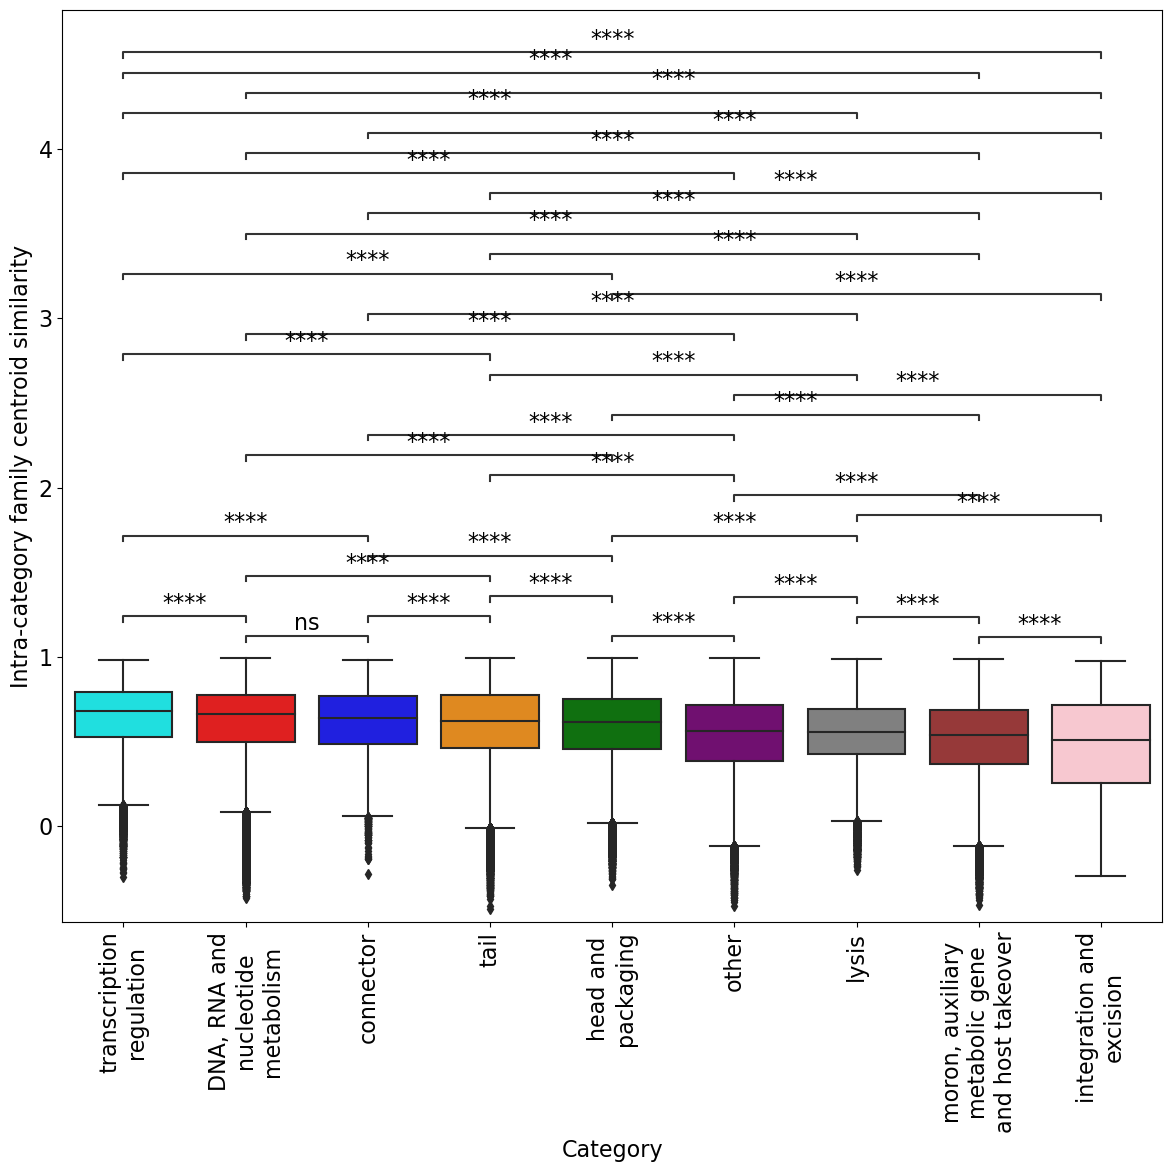

In [16]:
ax = sns.boxplot(
    y='similarity',
    x='revised_category_v4',
    palette=phrog_palette,
    data=df_cat_dists,
    order=my_order
)
ax.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

annotator = Annotator(ax, 
                      pairs, 
                      data=df_cat_dists, 
                      y='similarity',
                      x='revised_category_v4',
                      order=my_order)
annotator.configure(test='t-test_ind', text_format='star', comparisons_correction='bonferroni', verbose=1)
annotator.apply_and_annotate();

ax.set_xlabel('Category')
ax.set_ylabel('Intra-category family centroid similarity')

plt.tight_layout()

# figure 4b

In [17]:
cat_vs_cat_dists = []
cat_vs_cat = {}
for i in range(len(cs)):
    c = list(cs)[i]
    dic = {}
    d = phrog_dists[phrog_dists['revised_category_v4'] == c]
    
    for j in range(len(cs)):
        
        if i == j:
            continue
        
        cc = list(cs)[j]
        nd = phrog_dists[phrog_dists['revised_category_v4'] == cc]

        c_vecs = []
        nd_vecs = []

        for ph in d['#phrog']:
            c_vecs.append(pickle.load(open('phrog_centroid/{0}.pkl' ''.format(ph), 'rb')))

        for ph in nd['#phrog']:
            nd_vecs.append(pickle.load(open('phrog_centroid/{0}.pkl' ''.format(ph), 'rb')))

        c_vecs = np.array(c_vecs)
        nd_vecs = np.array(nd_vecs)

        sims = metrics.pairwise.cosine_similarity(c_vecs, nd_vecs)



        m_sims = np.mean(sims, axis=0)
        mm_sims = np.mean(m_sims, axis=0)

        cat_vs_cat_dists.append(zip([c]*len(m_sims), [cc]*len(m_sims), m_sims))
        
        if j > i:
            dic[cc] = {'weight': mm_sims}
    if len(dic) > 0:
        cat_vs_cat[c] = dic

cat_vs_cat_dists = [x for y in cat_vs_cat_dists for x in y]
df_cat_vs_cat_dists = pd.DataFrame(cat_vs_cat_dists, columns=['label1', 'label2', 'similarity'])
df_cat_vs_cat_dists.sort_values(by='label1', inplace=True)

In [18]:
G = nx.from_dict_of_dicts(cat_vs_cat)

In [19]:
nodelist = G.nodes()

In [20]:
network_colors = [phrog_palette[cc] for cc in nodelist]

In [21]:
plt.rcParams["figure.figsize"] = (22,16)
plt.rcParams['font.size'] = 36

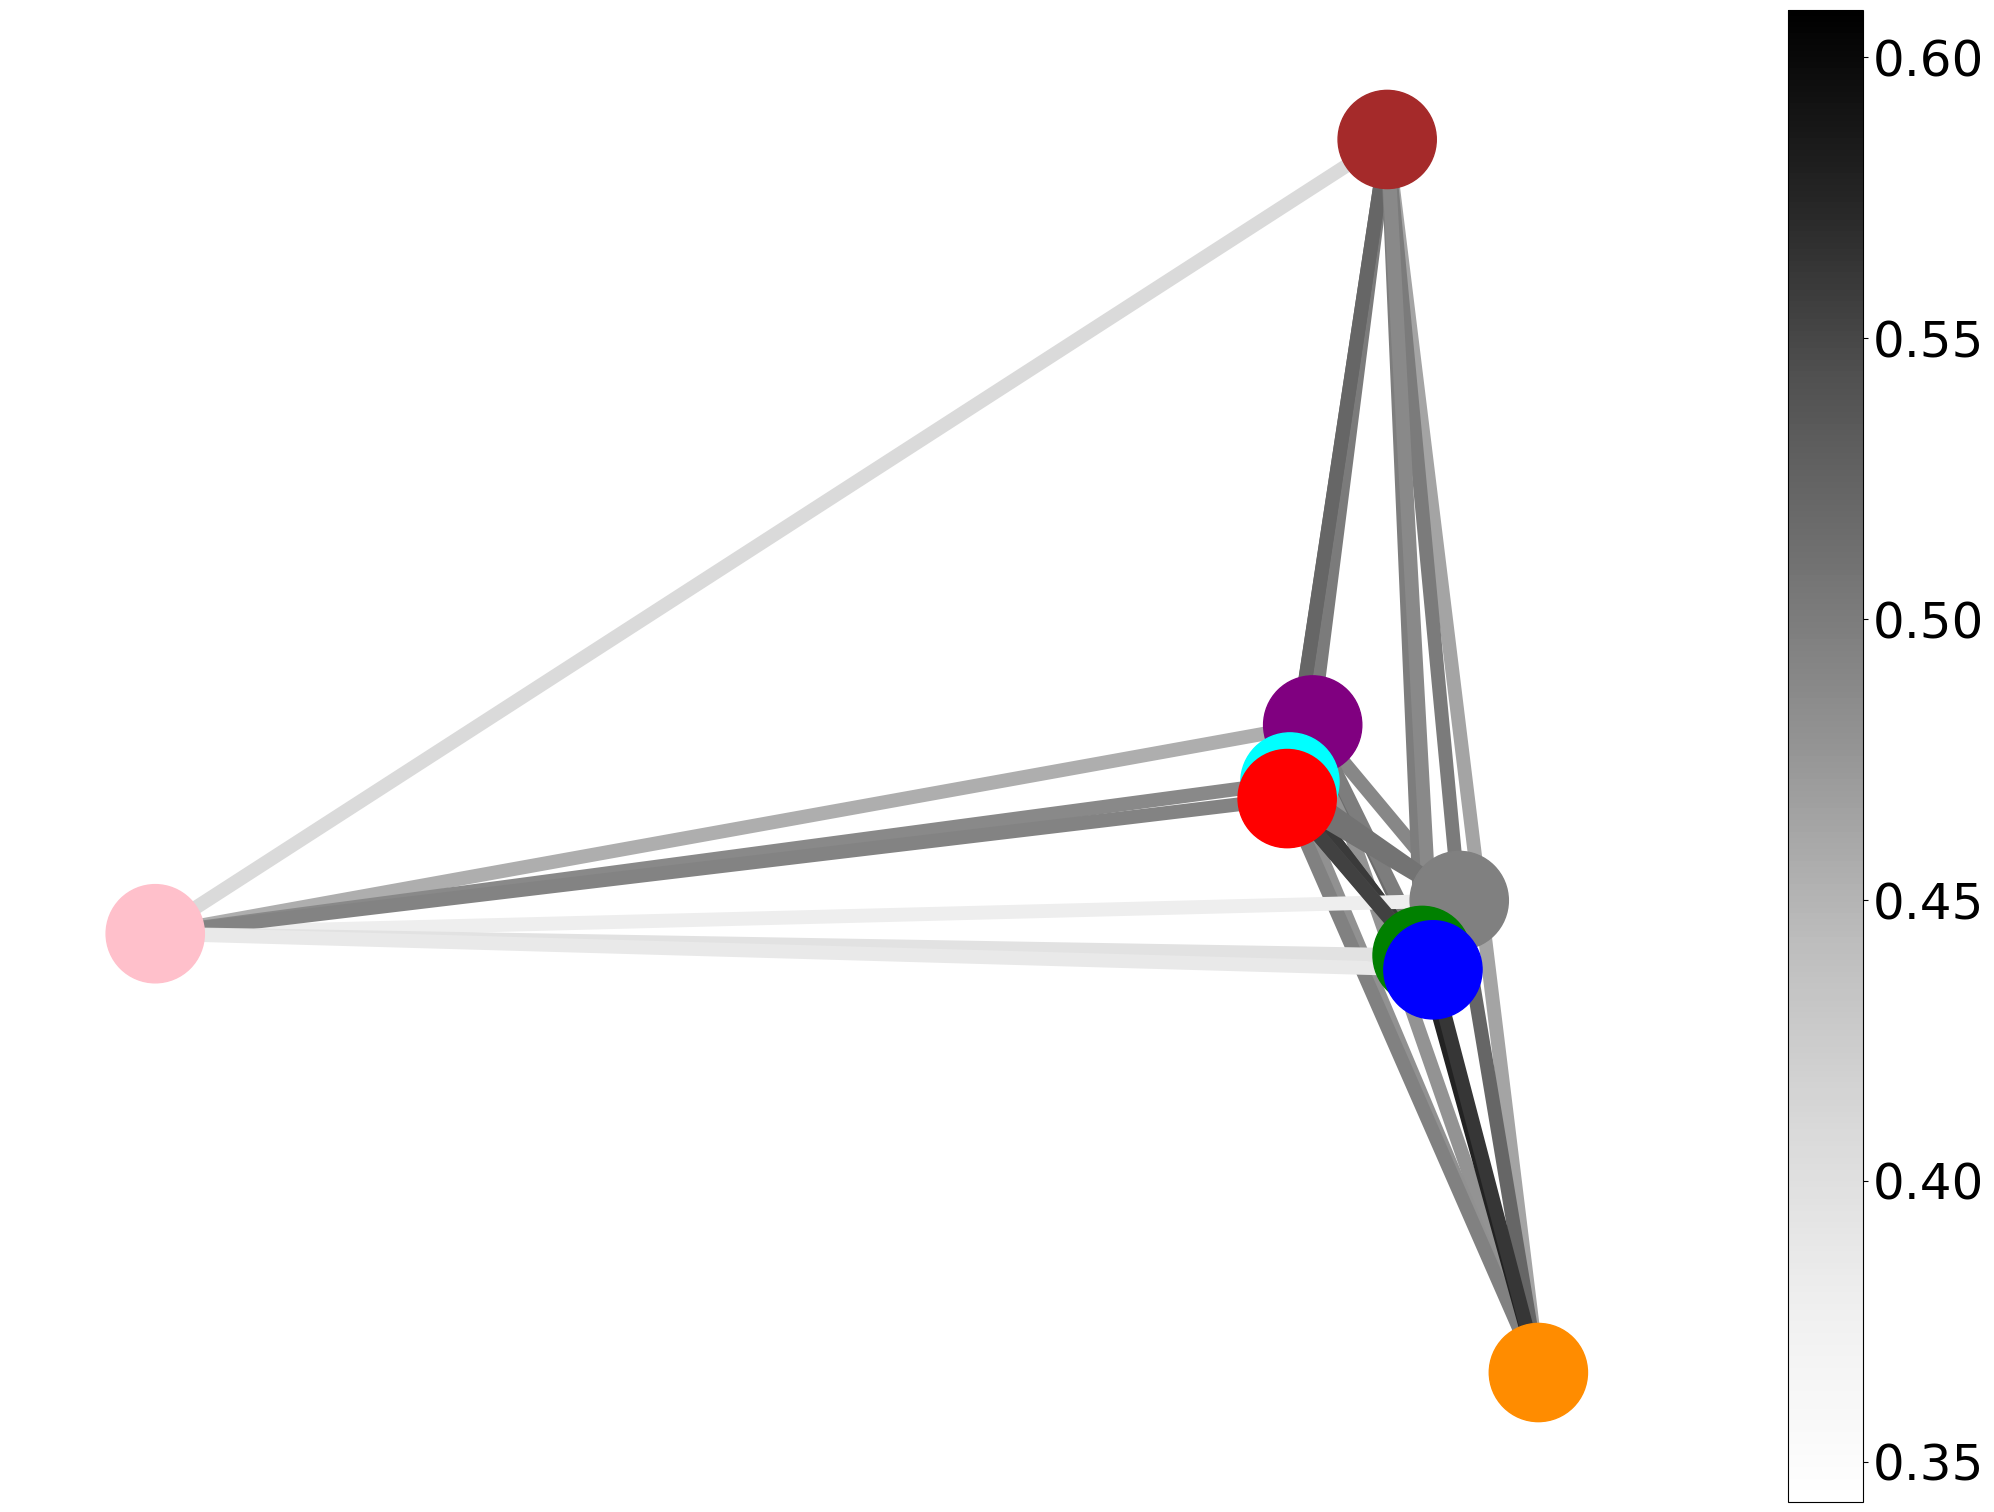

In [22]:
widths = nx.get_edge_attributes(G, 'weight')
nodelist = G.nodes()

pos = nx.spectral_layout(G)
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=5000,
                       node_color=network_colors
                      )
nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=10,
                       #edge_color=list(widths.values()) / max(list(widths.values())),
                       edge_color=list(widths.values()),
                       edge_cmap=plt.cm.Greys
                      )


for v in set(nodelist):
    plt.scatter([],[], c=phrog_palette[v], label=v)

plt.box(False)
plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=min(list(widths.values())), vmax=max(list(widths.values())), clip=False), 
                                   cmap=plt.cm.Greys))

plt.tight_layout()
plt.savefig('inter_category_similarities_network_spectral.png', dpi=300)
plt.show()

## attempts to cluster the family-family similarity matrix

In [23]:
pairwise_similarity_dict = {(k,v):cat_vs_cat[k][v]['weight'] for k in cat_vs_cat.keys() for v in cat_vs_cat[k].keys()}

In [24]:
dist_list = [dist[1] for dist in pairwise_similarity_dict.items()]

In [25]:
df_clustering = pd.DataFrame(squareform(dist_list), index=list(cs), columns=list(cs))

In [26]:
clustering = SpectralClustering(n_clusters=2, affinity='precomputed').fit(df_clustering)

In [27]:
clustering.labels_

array([0, 0, 1, 0, 0, 1, 0, 1, 1], dtype=int32)

In [28]:
cs

{'DNA, RNA and nucleotide metabolism',
 'connector',
 'head and packaging',
 'integration and excision',
 'lysis',
 'moron, auxiliary metabolic gene and host takeover',
 'other',
 'tail',
 'transcription regulation'}